In [1]:
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
%store -r f_trp
%store -r f_trees
%store -r joined_df

In [3]:
# Read data into geodataframes (tracts with population data and trees geodataframes) and
# ensure spatial consistency by checking both CRSs

tracts = f_trp # filtered tract population geodataframe from previous notebook
trees = f_trees # filtered trees geodataframe from previous notebook

In [4]:
tracts.head(2)

,GEOID,geometry,name,population,state,county,tract
1,36061000201,"POLYGON ((988547.752 197773.594, 987978.309 19...","Census Tract 2.01, New York County, New York",2761.0,36,061,000201
2,36061000600,"POLYGON ((986960.619 199556.761, 987205.694 19...","Census Tract 6, New York County, New York",10628.0,36,061,000600


In [5]:
trees.head(2)

,most_recent_observation,common_name,city,condition,geometry
0,8/27/2015,Red maple,New York,fair,POINT (1027431.176 202757.023)
1,9/3/2015,Pin oak,New York,fair,POINT (1034455.726 228645.09)


In [6]:
print(tracts.crs, trees.crs)

EPSG:2263 EPSG:2263


In [7]:
# Read the spatial join of trees and tract population geodataframes from memory
trees_in_tracts = joined_df # spatial join from previous notebook

In [8]:
trees_in_tracts.count()

most_recent_observation    683690
common_name                652072
city                       683690
condition                  652075
geometry                   683690
index_right                683690
GEOID                      683690
name                       683690
population                 683690
state                      683690
county                     683690
tract                      683690
dtype: int64

### Count trees per tract

In [9]:
# Group by tract ID and count the number of trees in each tract
tree_counts = trees_in_tracts.groupby("GEOID").size().reset_index(name="tree_count")

In [10]:
tree_counts.count()

GEOID         2307
tree_count    2307
dtype: int64

### Calculate tract area

In [11]:
# Calculate area for each tract in square kilometers
tracts["area_km2"] = tracts.geometry.area * 9.2903e-8  # Convert from square feet to square kilometers

### Combine tree counts with tract area

In [12]:
# Merge tree counts into tracts GeoDataFrame
tracts = tracts.merge(tree_counts, on="GEOID", how="left")
# Fill NaN tree counts with 0 for tracts with no trees
tracts["tree_count"] = tracts["tree_count"].fillna(0)

### Calculate tree and population density (trees and population per square kilometer)

In [13]:
tracts["tree_density"] = tracts["tree_count"] / tracts["area_km2"]
tracts['population_density'] = tracts['population'] / tracts['area_km2']

### Spatial analysis

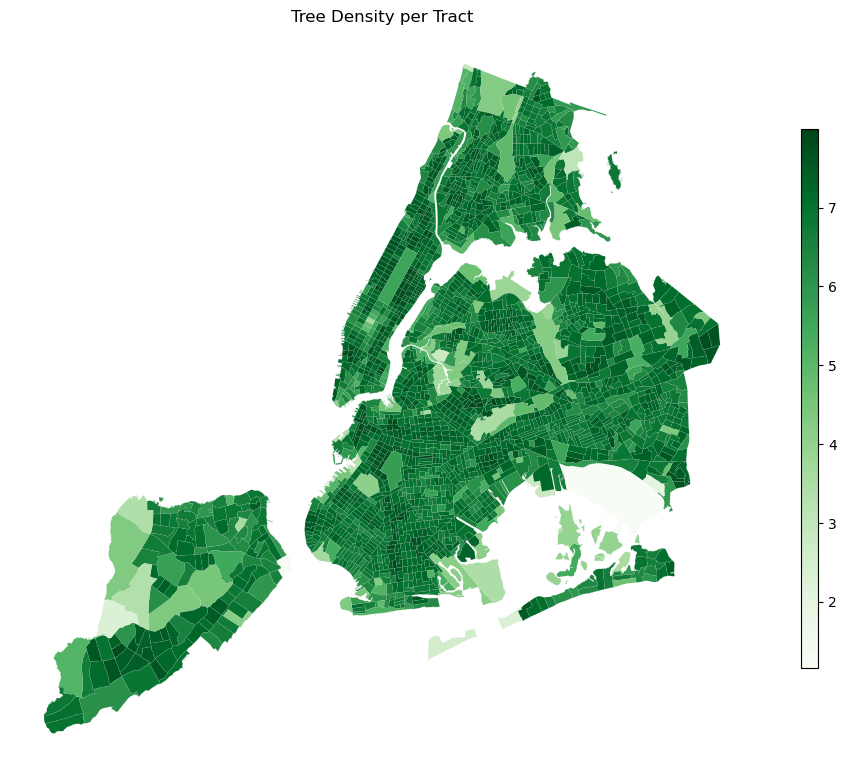

In [14]:
# Logarithmically scale population density, ensuring no zero values for log scale
tracts["log_tree_density"] = np.log1p(tracts["tree_density"])  # log1p = log(1 + x) to handle zero safely

# Map 1: Tree Density (Log Scale)
fig, ax = plt.subplots(figsize=(12, 10))  # Force figure size
tracts.plot(
    column="log_tree_density",
    cmap="Greens",
    legend=True,
    edgecolor="lightgrey",
    linewidth=0.05,
    legend_kwds={"shrink": 0.7, "aspect": 30},  # Resize legend
    ax=ax  # Use the explicit AxesSubplot
)
ax.set_title("Tree Density per Tract", fontsize=12)
ax.axis('off')  # Turn off axes
plt.show()

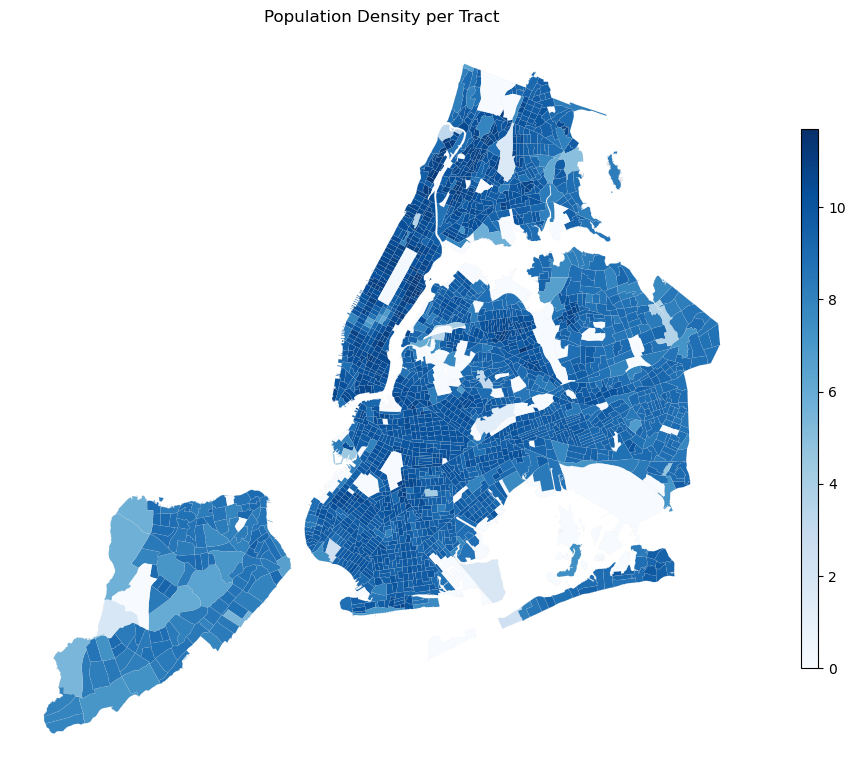

In [15]:
# Logarithmically scale population density
tracts["log_population_density"] = np.log1p(tracts["population_density"])

# Map 2: Population Density (Log Scale)
fig, ax = plt.subplots(figsize=(12, 10))  # Force figure size
tracts.plot(
    column="log_population_density",
    cmap="Blues",
    legend=True,
    edgecolor="lightgrey",
    linewidth=0.05,
    legend_kwds={"shrink": 0.7, "aspect": 30},  # Resize legend
    ax=ax  # Use the explicit AxesSubplot
)
ax.set_title("Population Density per Tract", fontsize=12)
ax.axis('off')  # Turn off axes
plt.show()

### Spatial Correlation Analysis: Tree Density vs, Population Density

Correlation between Tree Density and Population Density: 0.42


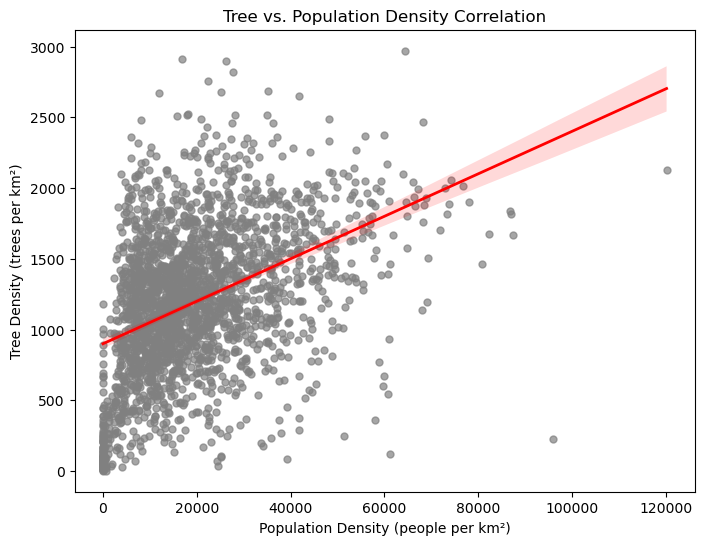

In [16]:
# Compute Correlation Coefficient
correlation = tracts["tree_density"].corr(tracts["population_density"])
print(f"Correlation between Tree Density and Population Density: {correlation:.2f}")

plt.figure(figsize=(8, 6))

# Use regplot to add a regression line (trendline)
sns.regplot(data=tracts, x="population_density", y="tree_density", scatter_kws={'s': 25, 'color': 'gray', 'alpha': 0.7}, line_kws={'color': 'red', 'lw': 2})

# Title and labels
plt.title("Tree vs. Population Density Correlation")
plt.xlabel("Population Density (people per km²)")
plt.ylabel("Tree Density (trees per km²)")

# Axis and Grid
plt.axis('on')  # Hides both x and y axes
plt.grid(False)  # Disable grid lines

plt.show()

### Analyze Tree Density vs. Population Density

In [17]:
# Statistical Summary

In [18]:
print("Tree Density Stats:")
print(tracts["tree_density"].describe())
print("\nPopulation Density Stats:")
print(tracts["population_density"].describe())

Tree Density Stats:
count    2307.000000
mean     1192.465762
std       520.173237
min         2.181761
25%       867.486418
50%      1206.258371
75%      1532.822205
max      2970.691068
Name: tree_density, dtype: float64

Population Density Stats:
count      2307.000000
mean      19516.723714
std       14428.383706
min           0.000000
25%        9248.180045
50%       16259.109031
75%       26363.690816
max      120213.116364
Name: population_density, dtype: float64


In [19]:
# Visualize Data Distributions

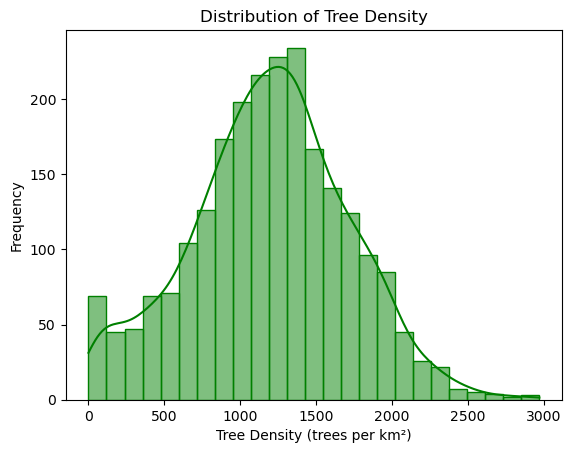

In [20]:
# Histogram for Tree Density

sns.histplot(tracts["tree_density"], kde=True, color="green", bins=25, edgecolor="green")
plt.title("Distribution of Tree Density")
plt.xlabel("Tree Density (trees per km²)")
plt.ylabel("Frequency")
plt.show()

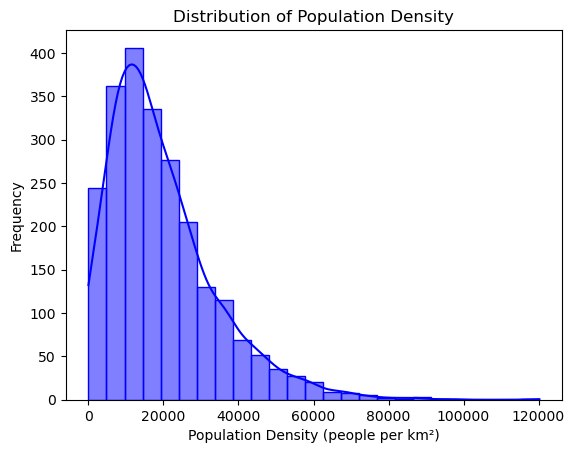

In [21]:
# Histogram for Population Density

sns.histplot(tracts["population_density"], kde=True, color="blue", bins=25, edgecolor="blue")
plt.title("Distribution of Population Density")
plt.xlabel("Population Density (people per km²)")
plt.ylabel("Frequency")
plt.show()

In [22]:
# Subgroup Analysis

In [23]:
# Categorize tracts into subgroups based on population density quartiles
low_cutoff = tracts["population_density"].quantile(0.25)
medium_cutoff = tracts["population_density"].quantile(0.75)

def categorize_density(pop_density):
    if pop_density < low_cutoff:
        return "Low"
    elif pop_density < medium_cutoff:
        return "Medium"
    else:
        return "High"

tracts["density_category"] = tracts["population_density"].apply(categorize_density)

# Verify the distribution of categories
print(tracts["density_category"].value_counts())

# Correlation within each subgroup
print("\nCorrelation within redefined subgroups:")
for category in ["Low", "Medium", "High"]:
    subset = tracts[tracts["density_category"] == category]
    correlation = subset["tree_density"].corr(subset["population_density"])
    print(f"  - {category}-density areas: {correlation:.2f}")

density_category
Medium    1153
High       577
Low        577
Name: count, dtype: int64

Correlation within redefined subgroups:
  - Low-density areas: 0.62
  - Medium-density areas: 0.15
  - High-density areas: 0.18


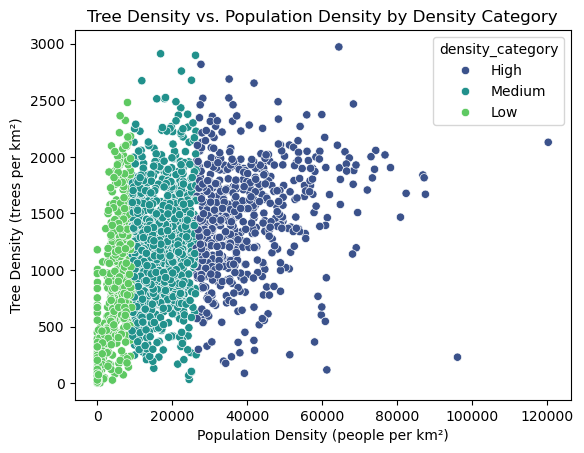

In [24]:
# Scatter Plot with Subgroups

sns.scatterplot(data=tracts, x="population_density", y="tree_density", hue="density_category", palette="viridis")
plt.title("Tree Density vs. Population Density by Density Category")
plt.xlabel("Population Density (people per km²)")
plt.ylabel("Tree Density (trees per km²)")
plt.grid(False)
plt.show()